<font size="5">Run the ANUGA Model (BYOAM) </font>

<font size="3">In this notebook, we will:

- initiate the model with elevation, friction, stage
- set the boundary conditions
- run the model!



</font>

<font size="3">Before you can run this notebook, you should have run the 4_Build_ANUGA_Mesh</font>


<font size=5> Step #1: Mount Google Drive and Grant Access <font> <br>




<font size=3> When you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>


In [14]:
import sys
import os
path = os.getcwd() + '/'
where_to_mount = '/content/drive/'

from google.colab import drive
drive.mount(where_to_mount, force_remount=True)

mounted_drive = where_to_mount + 'MyDrive/'

Mounted at /content/drive/


<font size=5> Step #2: Install packages. <font> <br>
<font size=3> This cell should install all Python packages you need for each tutorial.<font>

In [15]:
import os
os.chdir(mounted_drive)
if os.path.isdir(mounted_drive + 'komo_estuary_tutorial'):
  print('## Updating the local git repository \n')
  os.chdir(mounted_drive + '/komo_estuary_tutorial')
  ! git pull 
else:
  print('## Pulling the git repository with files for the tutorial\n')
  ! git clone https://github.com/achri19/komo_estuary_tutorial.git

print('\n## Installing the Python packages needed for these tutorials\n')
!/bin/bash $mounted_drive/komo_estuary_tutorial/install_packages.sh


## Updating the local git repository 

Already up to date.

## Installing the Python packages needed for these tutorials

(1) Install pip packages to /content/drive/MyDrive/installations
nose mpi4py triangle Pmw pymetis cmocean geopandas fiona pygeos rasterio rasterstats scikit-fmm rtree pyTMD Orinoco
(2) Install gdal
(3) Install netcdf4
(4) Download anuga_core github repository
https://github.com/GeoscienceAustralia/anuga_core
(5) Install anuga
(7) Completed


<font size=5> Step #3: Set up working directories<font> 


<font size=3> We will access data files stored on a shared Google Drive. You will also need to save files to your own Google Drive.<font>



In [16]:
path = mounted_drive + '/processing/'
path_code = path + 'code/'
path_templates = path +  'templates/'
path_configs = path + 'configs/'
path_ancillary = path + 'ancillary/'
sys.path.insert(1,path_code)


<font size=5> Step #4: Now we will import Python packages, which will be used for future tutorials. If there are any errors, try rerunning the first cell <font> 




In [17]:
# Standard packages
import os
import time
import sys
import fnmatch
import numpy as np
import scipy
import scipy.interpolate
import pandas as pd
from datetime import datetime
from string import Template
import geopandas as gpd
from shapely.geometry import Polygon, Point
import rasterio
from pathlib import Path
from shapely.geometry import LineString
import gdal

## ANUGA packages
import anuga
from anuga.utilities.plot_utils import Make_Geotif
from anuga.coordinate_transforms.geo_reference import Geo_reference
from anuga.utilities import animate
from anuga import myid, numprocs, finalize, barrier, Inlet_operator
from anuga.parallel.parallel_inlet_operator import Parallel_Inlet_operator

## Plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

#mpl.rcParams['animation.ffmpeg_path'] = r'/Users/alchrist/Downloads/ffmpeg'
## If you get an error with producing animation plots, uncomment the line above and add directory for ffmpeg (r'/PATH/TO/ffmpeg')
import matplotlib.animation as animation
writer = animation.FFMpegWriter(fps=60)

from BYOM_Utilities_V1 import build_directory


<font size= 5 color = 'red'> Copy the AOI and elevationpath from the previous notebook into the cell below:

In [18]:
AOI = 'komo'

Path((mounted_drive + AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(mounted_drive, AOI)





Study area is komo
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/content/drive/MyDrive/komo/
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
##################### 8 Setup_F

<font size= 5 color = 'red'> Copy the AOI and elevationpath from the previous notebook into the cell below:

<font size=3> Give the name of your study area, must be the same in all notebooks </font>


In [27]:
elev_name = 'Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1m_30'
print('DEM = %s' %(elev_name))

mesh_name = mounted_drive + 'komo/Meshes/Meshes_base_100000m2/Meshes_base_100000m2.tsh'
print('MESH = %s' %(mesh_name))

inletLAT = 19092.
inletLON = 608911.
tideLAT = 31223.17
tideLON = 502794.61 
tideLAT_4326 = 0.2825
tideLON_4326 = 9.0253

boundary_types = ('Br','Bout')

DEM = Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1m_30
MESH = /content/drive/MyDrive/komo/Meshes/Meshes_base_100000m2/Meshes_base_100000m2.tsh


In [20]:
tide_data = np.genfromtxt("%s/Tide_LAT%s_LON%s/%s_tides_20100101.csv" %(folders[5],tideLAT_4326,tideLON_4326,AOI),delimiter=',')


<font size='5' color = 'red' > Make some plots! </font>


In [21]:
parameters = pd.read_csv(folders[6] + '/config_%s.csv' %(AOI))

EPSG = int(parameters['EPSG'])
landcovermethod = parameters['LandcoverMethod'][0]
discharge = 300

print(parameters.iloc[0] )

Unnamed: 0                                 0
Unnamed: 0.1                               0
AOI                                     komo
RiverOceanBoundary                      1260
Discharge                                426
LandcoverMethod                   WorldCover
LandElevMethod                         GLO30
OceanElevMethod                        GEBCO
LowerRiverElevMethod                   plane
UpperRiverElevMethod                 wdpower
WetlandElevMethod               constant_0.5
LakeElevMethod                    constant_1
ManningLUT                           default
WetlandClass                              90
WD_POWERA_upper                       0.0606
WD_POWERB_upper                       0.7732
MaxOceanDepth                           -300
MaxNearshoreDepth                       -300
MaxRiverDepth                           -300
MaxRiverWidth                            756
ulx                                   501794
lry                                    -2259
lrx       

In [22]:
now = datetime.now()
startdate = '20210101'
enddate = '20210103'
simu_length    = (datetime.strptime(enddate,'%Y%m%d')-datetime.strptime(startdate,'%Y%m%d')).days


In [23]:
scenario = '%s_%scms_%s_%s_%s_%s%s' %(AOI,discharge,startdate,elev_name.split('/')[-1][:-4],mesh_name.split('/')[-1][:-4],boundary_types[0],boundary_types[1])
print(scenario)
modelpath = folders[6] + scenario
print(modelpath)

Path((folders[6] + scenario)).mkdir(parents=True, exist_ok=True)



komo_300cms_20210101_Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1_Meshes_base_100000m2_BrBout
/content/drive/MyDrive/komo/Simulations/komo_300cms_20210101_Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1_Meshes_base_100000m2_BrBout


In [24]:
from rasterio.mask import mask
AOI_extent = gpd.read_file('%s%s_extent_%s.shp' %(folders[7],AOI,EPSG))
watermask = rasterio.open('%s%s_watermask_%s.tif' %(folders[8],AOI,res))
masked, mask_transform = mask(dataset=watermask,shapes=AOI_extent.geometry,crop=False)
masked = np.where(masked==-9999,np.nan,masked)

origin_x = watermask.profile['transform'][2]
origin_y = watermask.profile['transform'][5]


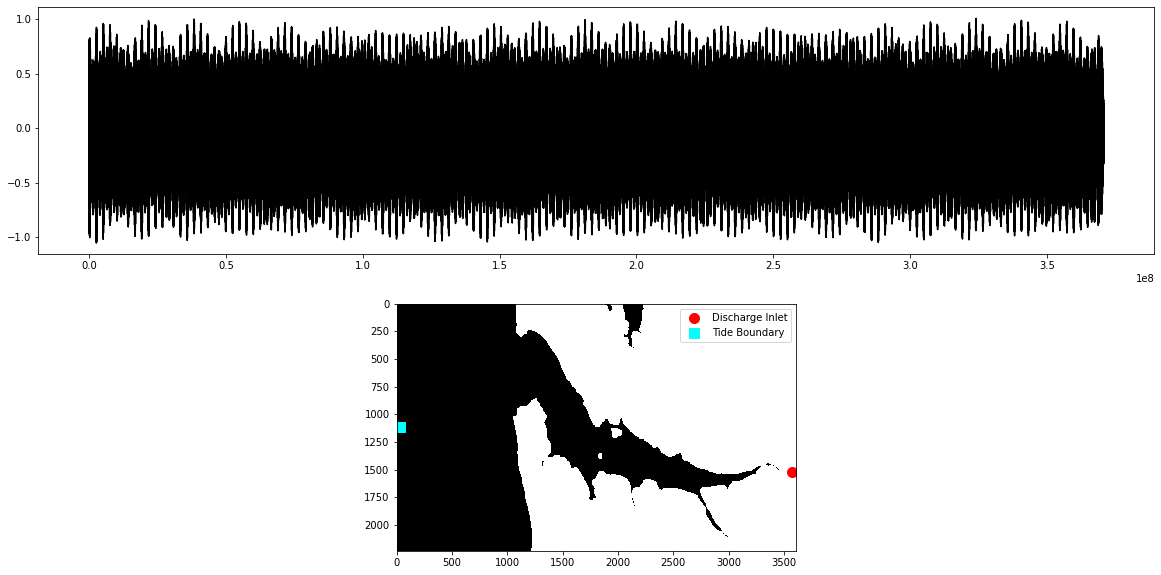

In [25]:
fig,[ax2,ax3] = plt.subplots(nrows=2,figsize=(20,10))

ax2.plot(tide_data[:,0],tide_data[:,1],'black')

ax3.imshow(masked[0],'gray')
ax3.scatter((inletLON-origin_x)/res,(origin_y - inletLAT)/res, s=100, c='red', marker='o',label='Discharge Inlet')
ax3.scatter((tideLON-origin_x)/res,(origin_y - tideLAT)/res, s=100, c='cyan', marker='s',label='Tide Boundary')
ax3.legend()

plt.savefig('%s/%s_model_boundaries_TideLAT%s_TideLON%s_InletLAT%s_InletLON%s.png' %(folders[5],AOI,tideLAT,tideLON,inletLAT,inletLON),bbox_inches='tight')

In [26]:
geo_reference = Geo_reference(zone=EPSG,
                                datum='wgs84',
                                projection='UTM',
                                false_easting=500000,
                                false_northing=0)

domain = anuga.create_domain_from_file(mesh_name)
domain.set_name(scenario) # Name of sww file
domain.set_datadir(modelpath)
domain.set_low_froude(1)
domain.set_flow_algorithm('DE1')
domain.set_minimum_allowed_height(0.02)
domain.report_water_volume_statistics
#print(domain.statistics())
domain.store_centroids = True
##############################################################################
##############################################################################

FileNotFoundError: ignored

In [ ]:
## Bed elevation
try:
    domain.set_quantity('elevation', filename= ('%s/%s.asc' %(folders[1],elev_name)), location = 'centroids')
except:
    gdal.Translate('%s/%s.asc' %(folders[1],elev_name), '%s/%s.tif' %(folders[4],elev_name), format='AAIGrid',noData =-9999)
    domain.set_quantity('elevation', filename= ('%s/%s.asc' %(folders[1],elev_name)), location = 'centroids')
    print('################################# Elevation made with:     %s_%s.asc' %(AOI,elev_name))
else:
    print('################################# Elevation set with:     %s_%s.asc' %(AOI,elev_name))


In [ ]:
## Manning roughness
try:
    domain.set_quantity('friction', filename= ('%s/%s_manning.asc' %(folders[1],AOI)), location='centroids')        # Constant friction
except:
    gdal.Translate('%s/%s_manning.asc' %(folders[1],AOI),'%s%s_manning_%s.tif' %(folders[8],AOI,landcovermethod),format='AAIGrid',noData=-9999)
    domain.set_quantity('friction', filename= ('%s/%s_manning.asc' %(folders[1],AOI)), location='centroids')        # Constant friction
print('################################# Friction set with:      %s_manning.asc' %(AOI))
print('')
print('')


In [ ]:
## Stage
domain.set_quantity('stage', -0.1,location='centroids')
print('################################# Initial stage set with at -0.1m')

In [ ]:
fig = plt.figure(figsize=(10,10))
dplotter = animate.Domain_plotter(domain,plot_dir = modelpath + '/plot/')
plt.triplot(dplotter.triang,linewidth=0.1)
plt.axis('scaled')
plt.tight_layout()
plt.savefig('%s/plot/mesh%s.png' %(modelpath,myid))

In [ ]:
domain.print_algorithm_parameters()

In [ ]:
start_tides = (datetime.strptime(startdate,'%Y%m%d') - datetime.strptime('20100101','%Y%m%d')).days * 24 +1
end_tides = start_tides + (simu_length) * 24 +1
stage_time_fun = scipy.interpolate.interp1d(
    tide_data[:simu_length*24+1, 0],
    tide_data[start_tides:end_tides, 1])



In [ ]:
domain.set_boundary({'North': anuga.Reflective_boundary(domain), 'East': anuga.Reflective_boundary(domain), 'South': anuga.Reflective_boundary(domain), 'West': anuga.Time_boundary(domain,function=lambda t: [stage_time_fun(t),0.0,0.0])})

In [ ]:
fig = plt.figure(figsize = (10,10), facecolor = 'w', edgecolor = 'k')
plt.plot(tide_data[:simu_length*24, 0], stage_time_fun(tide_data[:simu_length*24, 0]), color = 'black')
plt.xlabel("Simulation Time (seconds)")
plt.ylabel("Water Level (m)")
plt.title("Tide Estimations for %s-%s" %(startdate,enddate))
plt.savefig("%s/%s_tides.png" %(modelpath + '/plot',AOI))

print('################################# Boundaries set as: \nNorth: %s\nEast: %s\nSouth: %s\nWest: %s' %('Br','Br','Br','Bout'))


In [ ]:
## Set upstream discharge boundary
center = (inletLON,inletLAT)
radius = 5000
fixed_inflow = None


In [ ]:
line0 = [[center[0],center[1]],[center[0]-5,center[1]]]
fixed_inflow = Inlet_operator(domain,line0,Q=discharge,logging=True, description='upstream river', verbose = True)
if fixed_inflow is not None:
    print('################################# Discharge of %s m^3/s is input at (%s,%s)' %(discharge,center[0],center[1]))
    fixed_inflow.print_statistics()


In [ ]:
startnow = datetime.now()
print('################################# Starting Simulation at %s' %(startnow.strftime("%d/%m/%Y %H:%M:%S")))
print('################################# Simulation will run from %s to %s' %(startdate, enddate))
print('################################# Simulation length will be %s days, %s seconds' %(simu_length,simu_length*24*60*60))
print('################################# SWW file will be: ' + scenario )# Evolve system through time

sys.stdout.flush()

#------------------------------------------------------------------------------
for t in domain.evolve(yieldstep=900, duration=(simu_length*24*60*60)):
  domain.print_timestepping_statistics()
  #domain.report_water_volume_statistics()
  sys.stdout.flush()

endnow = datetime.now()
print('################################# Completed Simulation at %s' %(endnow.strftime("%d/%m/%Y %H:%M:%S")))

anuga.finalize()

<font size=5 color='red'> Done running the model. Move on to the next notebook 6_Post_Process.ipynb </font>


<font size=3 > The model takes about 5 minutes for 1 hour run time and a 48 hour simulation could take 4 hours. Therefore, to save time, we provided an output file for the next notebook </font>

In [ ]:
print(scenario)
print(modelpath)